In [3]:
!pip install pandas scikit-learn joblib --quiet



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib


In [5]:
filename = "summa.csv"
df = pd.read_csv(filename)
print(f"Loaded {filename} with shape {df.shape}")


Loaded summa.csv with shape (16, 4)


In [6]:
print("Columns in CSV:", df.columns)
print("Sample data:\n", df.head())


Columns in CSV: Index(['url', 'Type', 'api_subdomain', 'api_pathprefix'], dtype='object')
Sample data:
                                                  url      Type  \
0  https://docs.google.com/presentation/d/e/2PACX...  Phishing   
1    https://btttelecommunniccatiion.weeblysite.com/  Phishing   
2                        https://kq0hgp.webwave.dev/  Phishing   
3  https://brittishtele1bt-69836.getresponsesite....  Phishing   
4         https://bt-internet-105056.weeblysite.com/  Phishing   

                                       api_subdomain  \
0  https://api.docs.google.com/v1/presentation/d/...   
1  https://api.btttelecommunniccatiion.weeblysite...   
2  https://api.kq0hgp.webwave.dev/v1/?api_key=REP...   
3  https://api.brittishtele1bt-69836.getresponses...   
4  https://api.bt-internet-105056.weeblysite.com/...   

                                      api_pathprefix  
0  https://docs.google.com/api/v1/presentation/d/...  
1  https://btttelecommunniccatiion.weeblysite.com...

In [7]:
safe_apis = [
    {
        "url": "https://api.github.com/v1/users/octocat",
        "Type": "Safe",
        "api_subdomain": "https://api.github.com/v1/users/octocat",
        "api_pathprefix": "https://api.github.com/v1/users/octocat"
    },
    {
        "url": "https://api.spotify.com/v1/playlists/1234",
        "Type": "Safe",
        "api_subdomain": "https://api.spotify.com/v1/playlists/1234",
        "api_pathprefix": "https://api.spotify.com/v1/playlists/1234"
    },
    {
        "url": "https://api.twitter.com/2/tweets",
        "Type": "Safe",
        "api_subdomain": "https://api.twitter.com/2/tweets",
        "api_pathprefix": "https://api.twitter.com/2/tweets"
    }
]

df = pd.concat([df, pd.DataFrame(safe_apis)], ignore_index=True)
print("\nAfter adding safe APIs, dataset shape:", df.shape)



After adding safe APIs, dataset shape: (19, 4)


In [8]:
labels = df['Type'].astype(str).str.lower().map(lambda x: 1 if 'phishing' in x else 0)
print("\nLabels distribution:\n", labels.value_counts())



Labels distribution:
 Type
0    10
1     9
Name: count, dtype: int64


In [9]:
urls = pd.concat([df['api_subdomain'], df['api_pathprefix']], ignore_index=True)
labels_combined = pd.concat([labels, labels], ignore_index=True)
print(f"\nTotal dataset for training: {len(urls)} samples")



Total dataset for training: 38 samples


In [10]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3,5))
X = vectorizer.fit_transform(urls)
y = labels_combined
print("Feature matrix shape:", X.shape)


Feature matrix shape: (38, 2026)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [13]:
y_pred = clf.predict(X_test)
print("\nAccuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy on test set: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.50      0.67         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



In [14]:
df['prediction_subdomain'] = clf.predict(vectorizer.transform(df['api_subdomain']))
df['prediction_pathprefix'] = clf.predict(vectorizer.transform(df['api_pathprefix']))

df['prediction_subdomain'] = df['prediction_subdomain'].map({0:'Safe',1:'Malicious'})
df['prediction_pathprefix'] = df['prediction_pathprefix'].map({0:'Safe',1:'Malicious'})


In [15]:
df['overall_status'] = df.apply(
    lambda x: 'Malicious' if 'Malicious' in [x['prediction_subdomain'], x['prediction_pathprefix']] else 'Safe',
    axis=1
)


In [16]:
df.to_csv("summa_api_predictions.csv", index=False)
print("\nDone. Results saved to summa_api_predictions.csv")



Done. Results saved to summa_api_predictions.csv


In [17]:
print("\n=== Safe APIs ===")
safe_df = df[df['overall_status']=='Safe'][['api_subdomain','api_pathprefix','overall_status']]
print(safe_df.to_string(index=False))



=== Safe APIs ===
                                                                                                                                                                                               api_subdomain                                                                                                                                                                                               api_pathprefix overall_status
https://api.docs.google.com/v1/presentation/d/e/2PACX-1vTVj7OXwAUKJDv57jBmVg8eWFIUvTQ3c0-F1gPD_G5CwsQzOf3aelTqo4q42FIlqbHODnIlx2-Lx3Cf/pub?start=false&loop=false&delayms=3000&slide=id.p&api_key=REPLACE_ME https://docs.google.com/api/v1/presentation/d/e/2PACX-1vTVj7OXwAUKJDv57jBmVg8eWFIUvTQ3c0-F1gPD_G5CwsQzOf3aelTqo4q42FIlqbHODnIlx2-Lx3Cf/pub?start=false&loop=false&delayms=3000&slide=id.p&api_key=REPLACE_ME           Safe
                                                                                                                                   

In [18]:
print("\n=== Malicious APIs ===")
mal_df = df[df['overall_status']=='Malicious'][['api_subdomain','api_pathprefix','overall_status']]
print(mal_df.to_string(index=False))



=== Malicious APIs ===
                                                               api_subdomain                                                               api_pathprefix overall_status
   https://api.btttelecommunniccatiion.weeblysite.com/v1/?api_key=REPLACE_ME    https://btttelecommunniccatiion.weeblysite.com/api/v1/?api_key=REPLACE_ME      Malicious
                       https://api.kq0hgp.webwave.dev/v1/?api_key=REPLACE_ME                        https://kq0hgp.webwave.dev/api/v1/?api_key=REPLACE_ME      Malicious
https://api.brittishtele1bt-69836.getresponsesite.com/v1/?api_key=REPLACE_ME https://brittishtele1bt-69836.getresponsesite.com/api/v1/?api_key=REPLACE_ME      Malicious
        https://api.bt-internet-105056.weeblysite.com/v1/?api_key=REPLACE_ME         https://bt-internet-105056.weeblysite.com/api/v1/?api_key=REPLACE_ME      Malicious
                        https://api.teleej.weebly.com/v1/?api_key=REPLACE_ME                         https://teleej.weebly.com/api/

In [19]:
joblib.dump(clf, "api_sentinel_model.pkl")
joblib.dump(vectorizer, "url_vectorizer.pkl")
print("\nModel and vectorizer saved locally as:")
print(" - api_sentinel_model.pkl")
print(" - url_vectorizer.pkl")



Model and vectorizer saved locally as:
 - api_sentinel_model.pkl
 - url_vectorizer.pkl


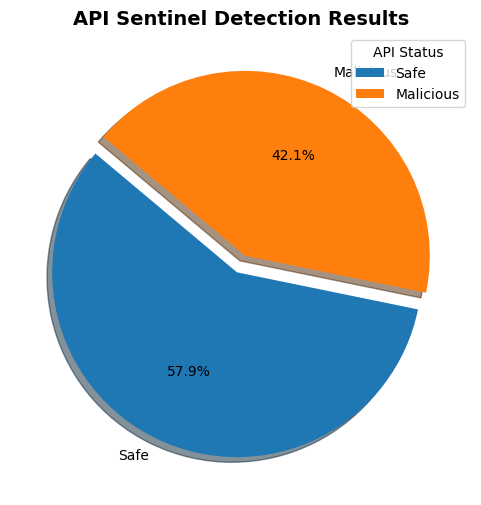

In [20]:
import matplotlib.pyplot as plt

status_counts = df['overall_status'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    shadow=True,
    explode=(0.05, 0.05) if len(status_counts) > 1 else None
)
plt.title("API Sentinel Detection Results", fontsize=14, fontweight='bold')
plt.legend(title="API Status", loc="upper right")
plt.show()
